# Prédiction de la probabilité de défaut 

# 1. Préparation des données

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn
import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Conv2D
from tensorflow.keras.optimizers import SGD,Adam,Nadam,Adadelta
from tensorflow import keras

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## a. Chargement des données

In [44]:
df = pd.read_csv('market_data_pd.csv',sep=',')
df.shape

(48836, 24)

In [45]:
df.sort_values('Error %', ascending=False).head()

,Unnamed: 0,Reference Security,Bid Price,Ask Price,Mid Price,Cpn,Maturity,Common Eqty / Tot Assets,Debt / Common Equity,TCE Ratio,...,Amt Out,Total Assets,BCLASS Level 3,Guarantee Type,Guarantor Type,Collat Type,PD_1y,reprice,maturity_years,Error %
5909,5909,ZS424035 Corp,0.010,0.750,0.3800,1.5000,04/26/2024,-147.17300,NaN,-149.82800,...,1.186770e+09,3359.72,Other Industrial,Multiple,Subsidiaries,SR SECURED,1.0,40.007513,2.709589,10428.292944
1456,1456,AN346569 Corp,0.125,0.700,0.4125,3.8750,10/25/2022,12.72580,177.366,-23.21850,...,4.000000e+08,1808.09,Electric,Multiple,Parent & Subsidiaries,SR SECURED,1.0,40.007513,1.205479,9598.791076
827,827,AL458635 Corp,0.250,1.750,1.0000,6.2500,06/15/2022,NaN,NaN,NaN,...,7.500000e+08,NaN,Consumer Cyclical,N.A.,N.A.,SR UNSECURED,1.0,42.507983,0.843836,4150.798276
44900,44900,QJ879163 Corp,0.407,1.481,0.9440,9.8776,12/01/2025,5.74708,467.713,4.97044,...,2.000000e+08,1002610.00,Banking,N.A.,N.A.,SUBORDINATED,1.0,40.007513,4.309589,4138.084024
44899,44899,QJ879163 Corp,0.396,1.499,0.9475,9.8776,12/01/2025,5.74708,467.713,4.97044,...,2.000000e+08,1002610.00,Banking,N.A.,N.A.,SUBORDINATED,1.0,40.007513,4.309589,4122.428832


In [46]:
def count_nan(df):
    for col_name in df.columns:
        n_nan = df[col_name].isna().sum()
        if n_nan > 0:
            print("Colomn : ", col_name)  
            print("NaN : {}/{}".format(n_nan,len(df[col_name])))
            print("===============================================")
            
#count_nan(df)

In [47]:
df = df[df.PD_1y>0.0]
df = df[df.PD_1y!=1.0]

df.columns

Index(['Unnamed: 0', 'Reference Security', 'Bid Price', 'Ask Price',
       'Mid Price', 'Cpn', 'Maturity', 'Common Eqty / Tot Assets',
       'Debt / Common Equity', 'TCE Ratio', 'Tot Debt / Tot Capital',
       'Tot Cap (Local Crncy)', 'Is Covered', 'Is Convertible', 'Amt Out',
       'Total Assets', 'BCLASS Level 3', 'Guarantee Type', 'Guarantor Type',
       'Collat Type', 'PD_1y', 'reprice', 'maturity_years', 'Error %'],
      dtype='object')

In [48]:
df1 = df[['Common Eqty / Tot Assets','TCE Ratio','Tot Debt / Tot Capital','Tot Cap (Local Crncy)','Is Covered','Is Convertible','Amt Out','BCLASS Level 3', 'Guarantee Type','Total Assets', 'Guarantor Type', 'Collat Type','Debt / Common Equity','PD_1y']]
df1 = df1[df1['Debt / Common Equity']<2500]
df1 = df1[df1['TCE Ratio']>-100]
#df1.replace(np.nan, 0.0,inplace=True)
df1.dropna(inplace=True)

In [49]:
df1.shape

(36781, 14)

In [50]:
df1

,Common Eqty / Tot Assets,TCE Ratio,Tot Debt / Tot Capital,Tot Cap (Local Crncy),Is Covered,Is Convertible,Amt Out,BCLASS Level 3,Guarantee Type,Total Assets,Guarantor Type,Collat Type,Debt / Common Equity,PD_1y
2,5.655220,5.412310,84.0491,1077950.000,False,False,1.000000e+09,Banking,N.A.,3040430.00,N.A.,SR UNSECURED,526.924,0.012445
3,35.988000,2.221370,53.9594,125576.000,False,False,6.060820e+08,Communications,N.A.,155063.00,N.A.,SR UNSECURED,121.425,0.020474
4,5.713810,5.246640,85.8881,333470.000,False,False,1.500000e+09,Banking,N.A.,809688.00,N.A.,SR UNSECURED,619.080,0.001146
5,23.508300,19.213600,63.4410,151388.000,False,False,6.000000e+08,Consumer Cyclical,Single,235381.00,Parent,COMPANY GUARNT,173.568,0.001179
6,4.547990,3.851140,85.6341,226753.000,False,False,1.100000e+09,Banking,N.A.,627244.00,N.A.,SR UNSECURED,680.681,0.002144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48817,12.191700,12.189800,86.0465,136118.000,False,False,3.860000e+07,Local Authority,Single,155787.00,Local Government,LOCAL GOVT GUARN,616.668,0.015262
48825,12.179400,12.154600,66.5225,2032.590,True,False,5.000000e+06,Mortgage Assets,N.A.,5586.66,N.A.,PFANDBRIEFE,198.720,0.023219
48826,4.907200,4.893530,94.7512,89085.000,False,False,5.265000e+05,Government Guaranteed,Single,95286.50,National/Sovereign Government,GOVT GUARANTEED,1805.190,0.003846
48828,5.819530,5.789880,93.5507,493031.000,False,False,3.200000e+07,Government Guaranteed,Single,546384.00,National/Sovereign Government,GOVT GUARANTEED,1450.560,0.013188


In [51]:
#df1 = df1.drop_duplicates(subset=df1.columns.difference(['PD_1y']))
df1.shape

(36781, 14)

In [52]:
df1 = df1.drop_duplicates()
df1.shape

(36096, 14)

## b. Traitement des données

Nous commencerons par séparer les données non étiquietées des étiquettes, les étiquettes se trouvent dans l'array `y_full` et le reste des données dans `X_full`

In [53]:
X_full = np.array(df1.drop(columns=['PD_1y']))
y_full = np.array(df1['PD_1y'])

La prochaine étape consiste à séparer les features continues des features discrètes, cela sera utile car leurs traitements seront différent

In [54]:
features = list(df1.drop(columns=['PD_1y']).columns)

discrete_features = ['BCLASS Level 3','Guarantee Type','Guarantor Type','Collat Type','Is Covered','Is Convertible']
continuous_features = [s for s in features if not s in discrete_features]


continuous_features_idx = [features.index(feat_name) for feat_name in continuous_features]
discrete_features_idx = [features.index(feat_name) for feat_name in discrete_features]

## i. Statistiques descriptives

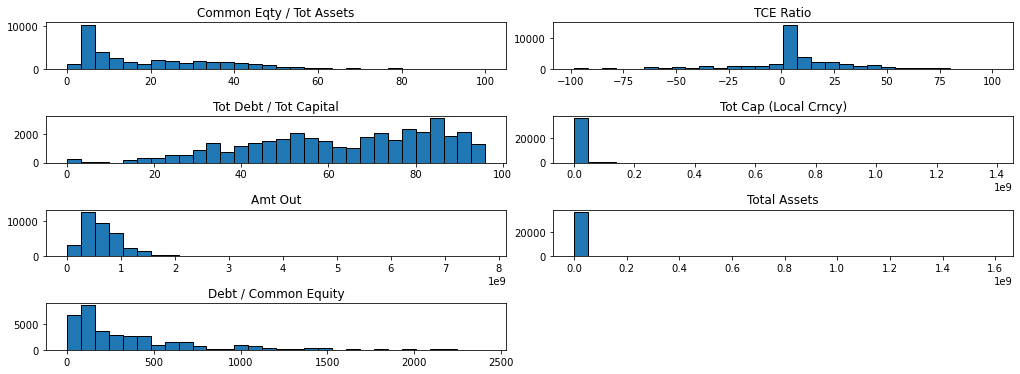

In [28]:
fig = plt.figure(figsize=(14,10))

# Histograms for continuous features
for (plot_idx, feat_idx) in enumerate(continuous_features_idx):

    # create a subplot in the (plot_idx+1) position of a 2x2 grid
    ax = fig.add_subplot(8, 2, (plot_idx+1))
    # plot the histogram of feat_idx
    h = ax.hist(X_full[:, feat_idx], bins=30, edgecolor='black')
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
    #plt.xlim(0,0.001)
# espacement entre les subplots
fig.tight_layout(pad=0.1)
#fig.savefig('continuous_distrib.png')

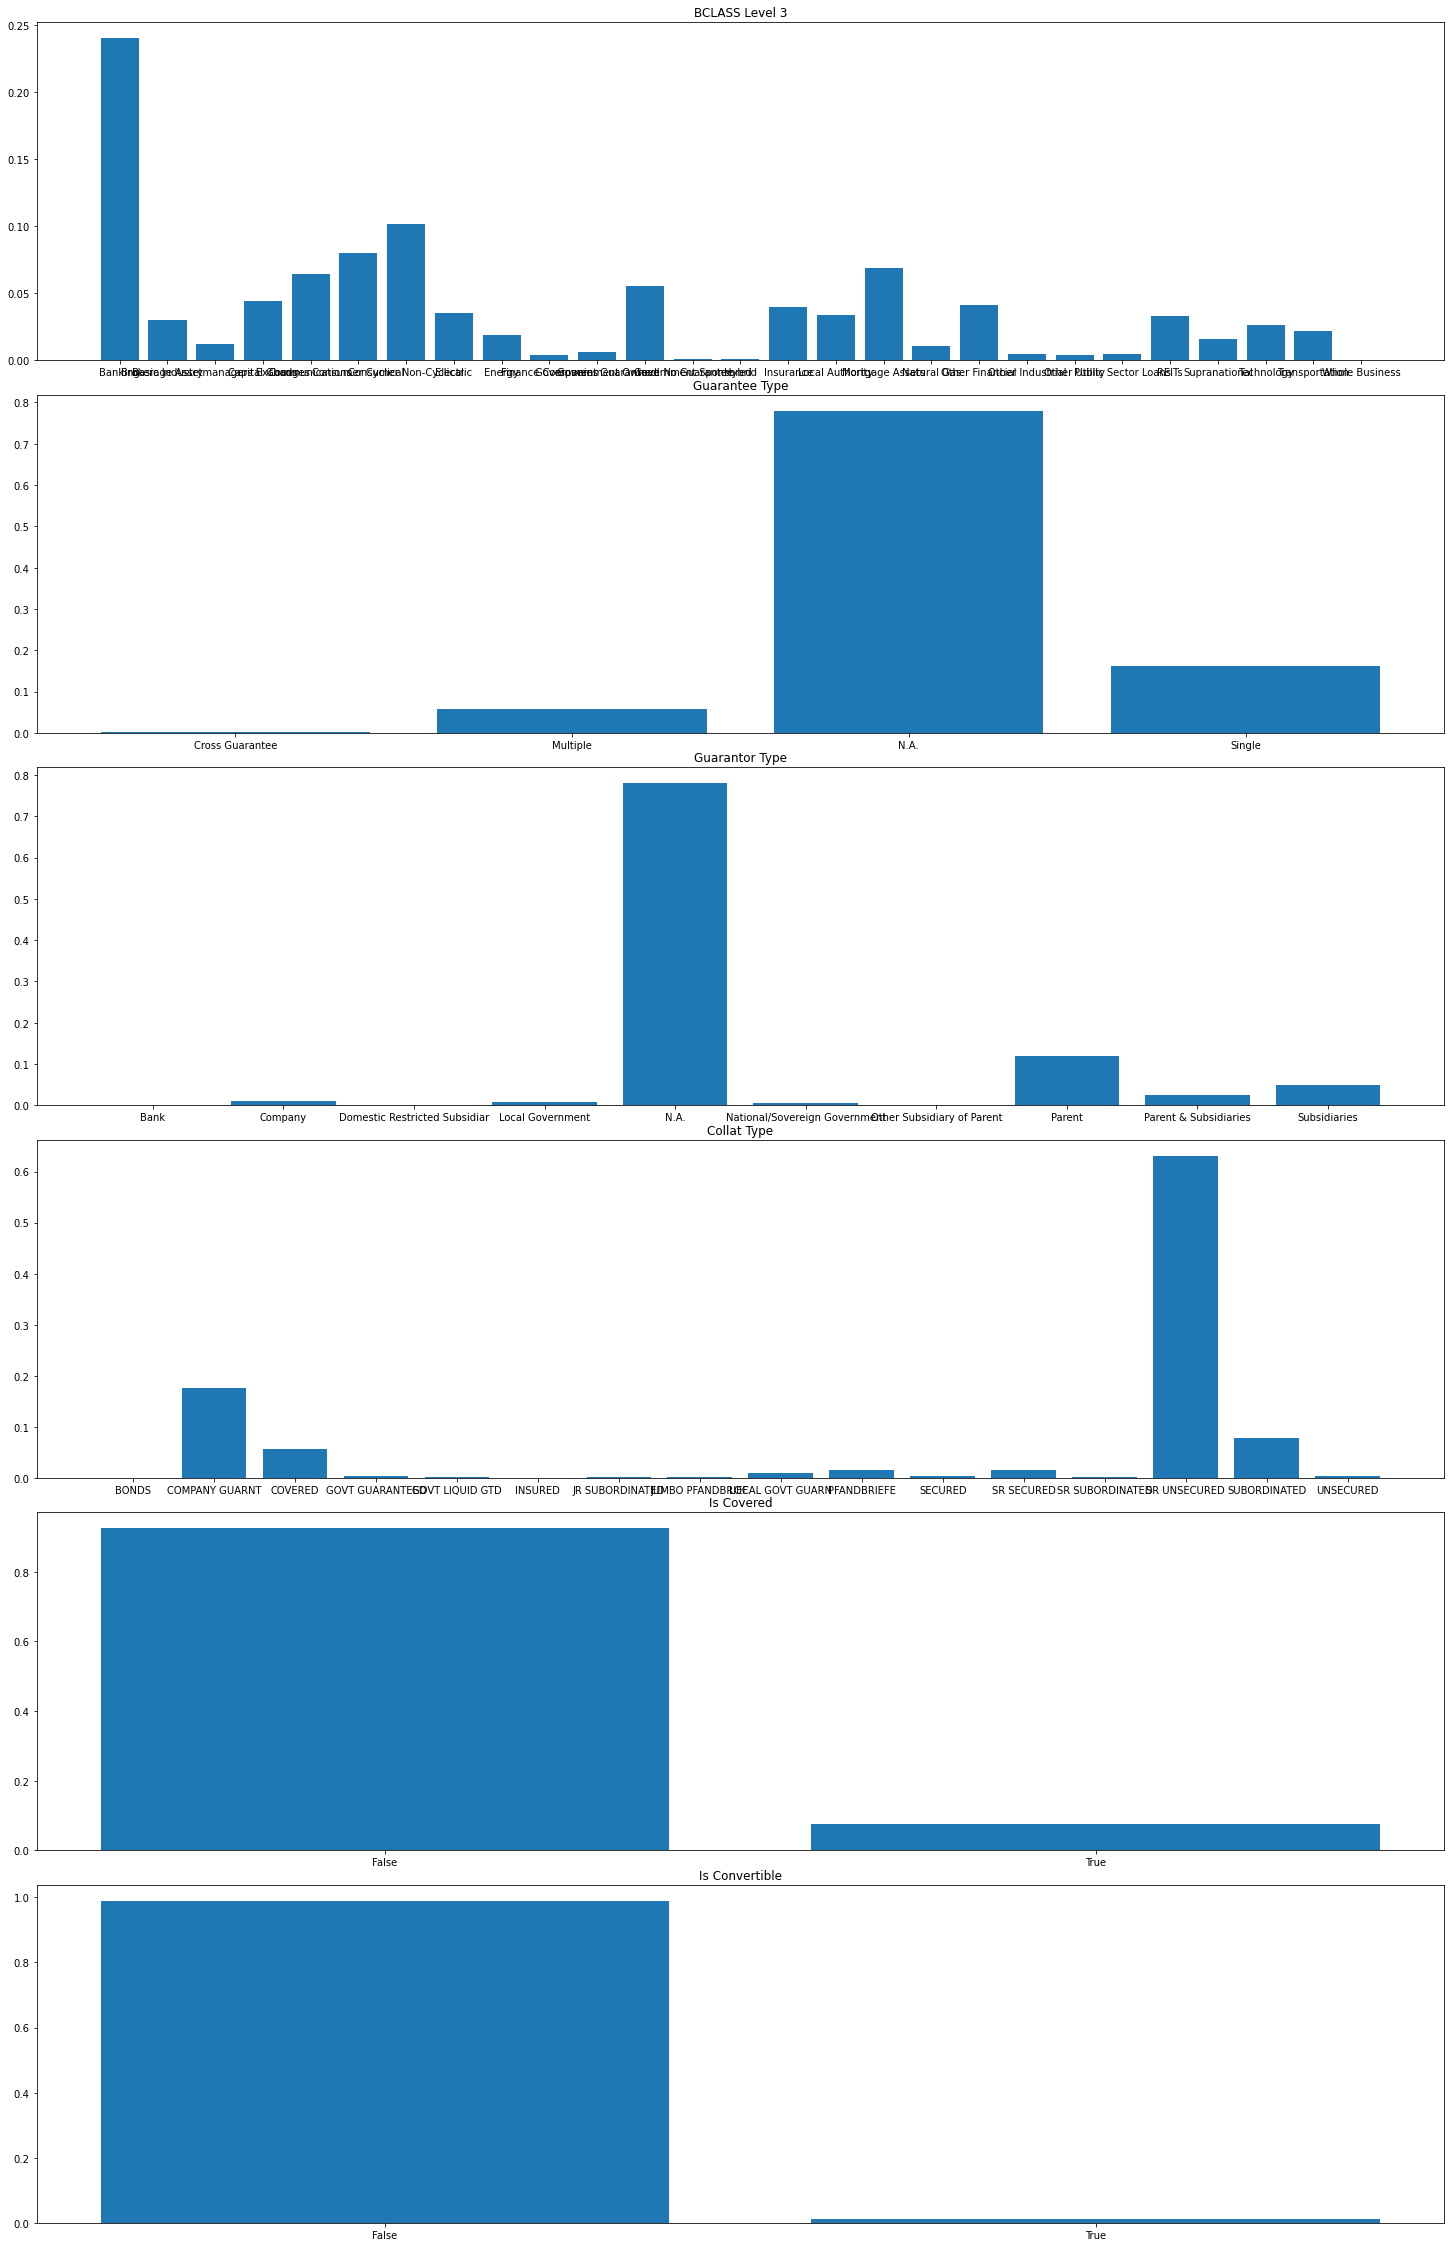

In [29]:
# Bar plots for discrete features
fig = plt.figure(figsize=(20, 36))

for (plot_idx, feat_idx) in enumerate(discrete_features_idx):
    # create a subplot in the (plot_idx+1) position of a 1x3 grid
    ax = fig.add_subplot(7, 1, (plot_idx+1))

    feature_values = np.unique(X_full[:, feat_idx])
    frequencies = [(float(len(np.where(X_full[:, feat_idx]==value)[0]))/X_full.shape[0]) \
                   for value in feature_values]
    
    b = ax.bar(range(len(feature_values)), frequencies, width=0.8, 
               tick_label=list([n for n in feature_values]))
    
    
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
    
fig.tight_layout(pad=0.15)
fig.savefig('discrete_distrib.png')

## ii. Traitement des données

In [55]:
## A FAIRE COMME CELA :
"""
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train_submit)

X_train_submit = enc.transform(X_train_submit)
X_test_submit = enc.transform(X_test_submit)

"""



class Pipeline:
    def __init__(self, X_train, X_full = None):
        """
        Se fit sur le jeu de TRAIN, une seule fois
        """
        self.ohe = preprocessing.OneHotEncoder(categories='auto',sparse=False).fit(X_full[:,discrete_features_idx])
        self.std_scaler = preprocessing.StandardScaler().fit(X_train[:,continuous_features_idx])
        print(self.ohe.categories_)
        
    def traitement(self,X):
        """
        Permet de traiter n'importe quel vecteur X ensuite
        """
    
        X_continuous_scaled = self.std_scaler.transform(X[:,continuous_features_idx])
        X_discrete_encoded = self.ohe.transform(X[:,discrete_features_idx])
        print('moyenne = {}'.format(np.mean(X_continuous_scaled)))
        
        X_processed = np.hstack((X_discrete_encoded, X_continuous_scaled))
    
        return X_processed

In [56]:
X_train, X_test_, y_train, y_test = model_selection.train_test_split(X_full, y_full, test_size=0.1,
                                                                    #stratify=y_full, # stratification
                                                                    random_state=92)

pipe = Pipeline(X_train,X_full)
X_train = pipe.traitement(X_train)
X_test  = pipe.traitement(X_test_)

[array(['Banking', 'Basic Industry', 'Brokerage Assetmanagers Exchanges',
       'Capital Goods', 'Communications', 'Consumer Cyclical',
       'Consumer Non-Cyclical', 'Electric', 'Energy', 'Finance Companies',
       'Government Guaranteed', 'Government Owned. No Guarantee',
       'Government Sponsored', 'Hybrid', 'Insurance', 'Local Authority',
       'Mortgage Assets', 'Natural Gas', 'Other Financial',
       'Other Industrial', 'Other Utility', 'Public Sector Loans',
       'REITs', 'Supranational', 'Technology', 'Transportation',
       'Whole Business'], dtype=object), array(['Cross Guarantee', 'Multiple', 'N.A.', 'Single'], dtype=object), array(['Bank', 'Company', 'Domestic Restricted Subsidiar',
       'Local Government', 'N.A.', 'National/Sovereign Government',
       'Other Subsidiary of Parent', 'Parent', 'Parent & Subsidiaries',
       'Subsidiaries'], dtype=object), array(['BONDS', 'COMPANY GUARNT', 'COVERED', 'GOVT GUARANTEED',
       'GOVT LIQUID GTD', 'INSURED', 'JR S

# 2. Modéles de prédiction des probabilités de défaut

Nous considérons les modèles de prédiction suivants : 

$-$ Réseau de neurones

$-$ k-NN 

$-$ SVR



## a. Réseau de neurones

## Entraînement du modèle

In [57]:
model = Sequential()
model.add(Dense(units=1200,input_dim=68,))#activation="sigmoid")) #6 is good
model.add(Dense(units=1200))
model.add(Dense(units=1200))
#model.add(Dropout(0.2))
model.add(Dense(units=1,activation="sigmoid"))

learning_rate = 0.000005

sgd = SGD(learning_rate)  #lr = 0.02
adam = Adam(learning_rate) #lr = 0.001

#nadam = Nadam(lr=0.0005, beta_1=0.9, beta_2=0.999)

In [58]:
model.compile(loss='mean_absolute_percentage_error',optimizer=adam,metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

In [59]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1200)              82800     
_________________________________________________________________
dense_5 (Dense)              (None, 1200)              1441200   
_________________________________________________________________
dense_6 (Dense)              (None, 1200)              1441200   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1201      
Total params: 2,966,401
Trainable params: 2,966,401
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
120/120 [==============================] - 5s 40ms/step - loss: 7340.4912 - mean_absolute_percentage_error: 7340.4912 - val_loss: 2716.6431 - val_mean_absolute_percentage_error: 2716.6431
Epoch 2/30
120/120 [==============================] - 5s 39ms/step - loss: 1680.1127 - mean_absolute_percentage_error: 1680.1127 - val_loss: 1175.2277 - val_mean_absolute_percentage_error: 1175.2278
Epoch 3/30
120/120 [==============================] - 5s 41ms/step - loss: 1555.7100 - mean_absolute_percentage_error: 1555.7100 - val_loss: 454.8592 - val_mean_absolute_percentage_error: 454.8592
Epoch 4/30
120/120 [==============================] - 5s 40ms/step - loss: 439.3262 - mean_absolute_percentage_error: 439.3262 - val_loss: 310.1262 - val_mean_absolute_percentage_error: 310.1262
Epoch 5/30
120/120 [==============================] - 5s 41ms/step - loss: 329.3359 - mean_absolute_percentage_error: 329.3359 - val_loss: 228.8564 - val_mean_absolute_percentage_error: 228.8564
Epoch 6/30
120/

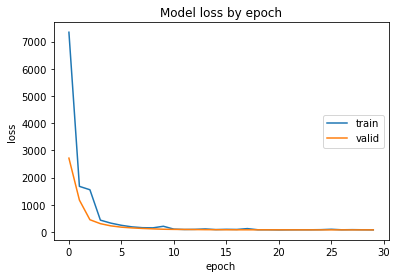

In [60]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
#callback = None
history = model.fit(np.squeeze(X_train), y_train,         # Train the model using the training set...
          batch_size=30, epochs=30,
          verbose=1, validation_split=0.2,steps_per_epoch=120,)#callbacks=[callback])           # ...holding out 40% of the data for validation

# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

    
import matplotlib.pyplot as plt

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
#plt.savefig('nn.png')
plt.show()

## Observation des résultats

*Fonctions pour afficher les résultats*

In [61]:
def ecart_relatif(row) : 
    théo = row['Théorique']
    préd = row['Prédiction']
    return np.abs(théo - préd) / théo

In [75]:
def ViewResults(model, X_test, y_test):
    prediction = pd.DataFrame(data= model.predict(X_test) ,columns=['Prédiction'])
    théorique = pd.DataFrame(data= y_test ,columns=['Théorique'])
    prediction, théorique = prediction.reset_index() , théorique.reset_index()

    results = pd.merge(théorique, prediction, on = 'index').drop(columns=['index'])
    results["Ecart_relatif"] = results.apply(ecart_relatif,axis=1)
    
    results.sort_values('Ecart_relatif',inplace=True)
    
    #print(results.tail(20))
    k=.2
    
    
    print("\n\nL'écart relatif moyen est de " + str(results["Ecart_relatif"].mean() * 100) + "%")
    premiere_bissectrice = np.linspace(0,k * 1e-1,100)
    
    plt.plot(premiere_bissectrice,premiere_bissectrice, color='red')
    plt.scatter(results["Théorique"],results["Prédiction"], s = 1)
    
    
    plt.xlim(-k*1e-2,k * 1e-1)
    plt.ylim(-k*1e-2,k * 1e-1)
    plt.savefig('svr_pred.png')
    plt.show()

*Résultats du réseau de neurones*

In [65]:
#Résultats 

resultat = model.evaluate(X_test, y_test, verbose=1)
print("Valeur de l'erreur sur les données de test (loss):", resultat[0])
print('Précision sur les données de test (MAPE):', resultat[1])

113/113 [==============================] - 1s 7ms/step - loss: 218.9731 - mean_absolute_percentage_error: 218.9731
Valeur de l'erreur sur les données de test (loss): 218.97311401367188
Précision sur les données de test (MAPE): 218.97311401367188


Resultat pour la regression via Dense Neural Net


L'écart relatif moyen est de 218.9731131817543%


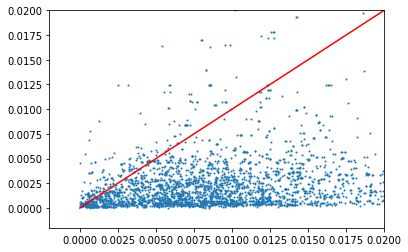

In [76]:
print('Resultat pour la regression via Dense Neural Net')
ViewResults(model,X_test,y_test)



L'écart relatif moyen est de 85.42126628514933%


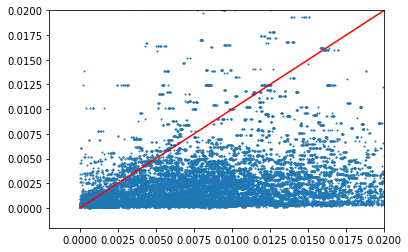

In [77]:
ViewResults(model,X_train,y_train)

## b. K-NN

*valeur de K à justifier*

In [70]:
from sklearn.neighbors import KNeighborsRegressor


neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.5312897255922633

Resultat pour la regression 3-NN


L'écart relatif moyen est de 158.51955314660097%


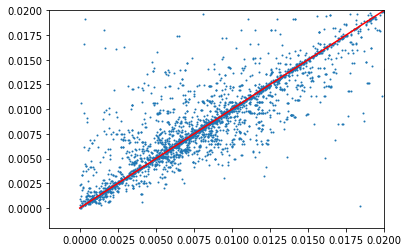

In [78]:
print('Resultat pour la regression 3-NN')
ViewResults(neigh,X_test,y_test)



L'écart relatif moyen est de 70.07239157256429%


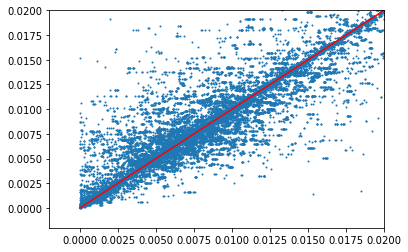

In [79]:
ViewResults(neigh,X_train,y_train)

## c. SVR

*valeur de la régression à justifier*

In [72]:
from sklearn.svm import SVR
regr = SVR(C=1.3789473684210527, epsilon=0.0000514545454545455, verbose=False)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.40535691630105575

Resultat pour la regression SVR


L'écart relatif moyen est de 212.69862747955256%


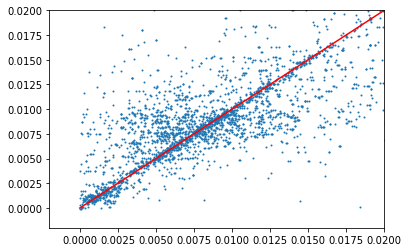

In [80]:
print('Resultat pour la regression SVR')
ViewResults(regr, X_test, y_test)